In [10]:
from __future__ import division

import datautils
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Read in the data
num_classes = 10
res = 128

tic = time.clock()
X_train, y_train, X_val, y_val, X_test, y_test, labels = datautils.get_data(num_classes=num_classes, res=128)
toc = time.clock()
print "Read {} images in {:5} seconds".format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0], toc - tic)
print "X_train: ", X_train.shape
print "y_train: ", y_train.shape
print "X_val: ", X_val.shape
print "y_val: ", y_val.shape
print "X_test: ", X_test.shape
print "y_test: ", y_test.shape

IndexError: tuple index out of range

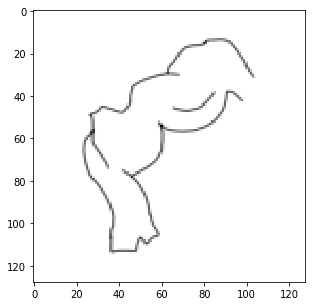

arm


In [25]:
# Plot a random image
sample = np.random.randint(X_train.shape[0])
plt.imshow(X_train[sample].reshape(128, 128))
plt.show()
print labels[y_train[sample]]

In [7]:
def model(X, y):
    c1 = tf.layers.conv2d(X, 32, [7, 7], padding='SAME') # 128 x 128 x 32
    b1 = tf.layers.batch_normalization(c1)
    h1 = tf.nn.relu(b1)
    p1 = tf.layers.max_pooling2d(h1, [2, 2], [2, 2]) # 64 x 64 x 32
    
    c2 = tf.layers.conv2d(p1, 64, [5, 5], padding='SAME') # 64 x 64 x 64
    b2 = tf.layers.batch_normalization(c2)
    h2 = tf.nn.relu(b2)
    p2 = tf.layers.max_pooling2d(h2, [2, 2], [2, 2]) # 32 x 32 x 64
    
    c3 = tf.layers.conv2d(p2, 128, [3, 3], padding = 'SAME') # 32 x 32 x 128
    b3 = tf.layers.batch_normalization(c3)
    h3 = tf.nn.relu(b3)
    p3 = tf.layers.max_pooling2d(h3, [2, 2], [2, 2]) # 16 x 16 x 128
    
    #p4 = tf.layers.average_pooling2d(p3, [32, 32], [1, 1]) # 1 x 1 x 64
    
    p3_flat = tf.reshape(p3, [-1,32768])
    y_out = tf.layers.dense(p3_flat, num_classes)
    
    return y_out
    
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, res, res, 1])
y = tf.placeholder(tf.int64, [None])

y_out = model(X, y)
print y_out.shape
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer()

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 10)


In [11]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx] }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

Iteration 0: with minibatch training loss = 32.3 and accuracy of 0.031
Iteration 10: with minibatch training loss = 12.6 and accuracy of 0
Epoch 1, Overall loss = 66.6 and accuracy of 0.0688


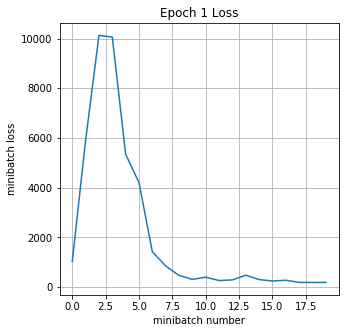

Iteration 20: with minibatch training loss = 4.6 and accuracy of 0.062
Iteration 30: with minibatch training loss = 2.62 and accuracy of 0.094
Epoch 2, Overall loss = 3.29 and accuracy of 0.0828


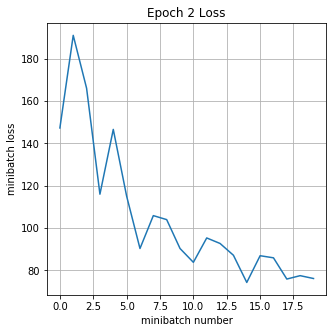

Iteration 40: with minibatch training loss = 2.38 and accuracy of 0
Iteration 50: with minibatch training loss = 2.23 and accuracy of 0.12
Epoch 3, Overall loss = 2.32 and accuracy of 0.134


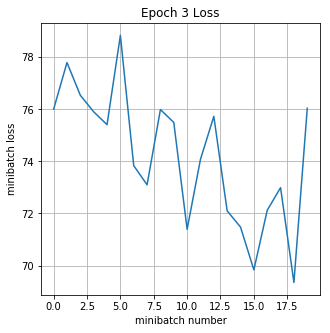

Iteration 60: with minibatch training loss = 2.32 and accuracy of 0.16
Iteration 70: with minibatch training loss = 2.12 and accuracy of 0.16
Epoch 4, Overall loss = 2.08 and accuracy of 0.294


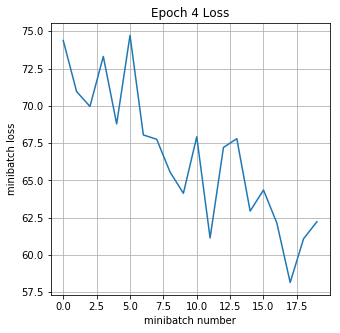

Iteration 80: with minibatch training loss = 1.95 and accuracy of 0.25
Iteration 90: with minibatch training loss = 1.54 and accuracy of 0.56
Epoch 5, Overall loss = 1.69 and accuracy of 0.447


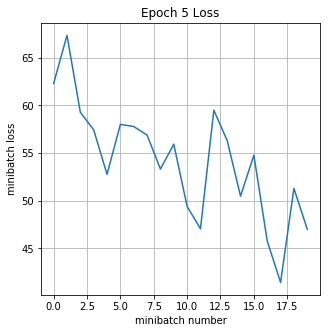

Epoch 1, Overall loss = 1.54 and accuracy of 0.463


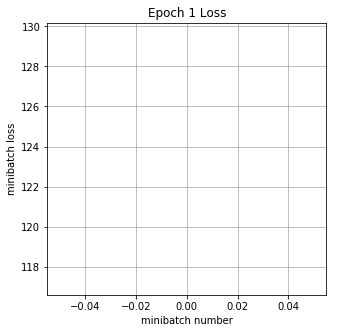

(1.5422687530517578, 0.46250000000000002)

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_train,
          yd=y_train,
          epochs=5,
          batch_size=32,
          print_every=10,
          training=train_step,
          plot_losses=True)
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_val,
          yd=y_val,
          epochs=1,
          batch_size=X_val.shape[0],
          print_every=1,
          training=None,
          plot_losses=True)